In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/results')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results/harem-ft_ELMo
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo+Embeddings


In [4]:
configs = dict()
metrics = dict()
for model_folder in path_results.iterdir():
    if 'Embeddings' in model_folder.name:
        #print('Reading embeddings folder from %s' % model_folder.name)
        for embedding_folder in model_folder.iterdir():
            #print('Reading trainings folder from %s' % embedding_folder.name)
            for training_folder in embedding_folder.iterdir():
                key = embedding_folder.name + '_' + training_folder.name
                #print('Reading files from %s' % key)
                has_metrics = False
                for results_file in training_folder.iterdir():
                    if results_file.name.endswith('.json'):
                        #print('Parsing data from %s' % results_file.name)
                        if results_file.name.startswith('config'):
                            configs[key] = json.loads(results_file.read_bytes())
                        elif results_file.name.startswith('metrics.'):
                            metrics[key] = json.loads(results_file.read_bytes())
                            has_metrics = True
                if not has_metrics:
                    print('metrics.json not found for %s' % key)
                    del configs[key]
    else:
        #print('Reading trainings folder from %s' % model_folder.name)
        for training_folder in model_folder.iterdir():
            key = training_folder.name
            #print('Reading files from %s' % key)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[key] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[key] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % key)
                del configs[key]
print(len(metrics))
print(len(configs))

1600
1600


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        embedding_type = data[3] if data[2] != 'glove' else 'No'
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft', 'ELMo', '4', '1']
['harem-ft', 'ELMo', '0', '0']
['harem-ft', 'ELMo', '0', '1']
['harem-ft', 'ELMo', '0', '2']
['harem-ft', 'ELMo', '0', '3']
['harem-ft', 'ELMo', '0', '4']
['harem-ft', 'ELMo', '1', '0']
['harem-ft', 'ELMo', '1', '1']
['harem-ft', 'ELMo', '1', '2']
['harem-ft', 'ELMo', '1', '3']
['harem-ft', 'ELMo', '1', '4']
['harem-ft', 'ELMo', '2', '0']
['harem-ft', 'ELMo', '2', '1']
['harem-ft', 'ELMo', '2', '2']
['harem-ft', 'ELMo', '2', '3']
['harem-ft', 'ELMo', '2', '4']
['harem-ft', 'ELMo', '3', '0']
['harem-ft', 'ELMo', '3', '1']
['harem-ft', 'ELMo', '3', '2']
['harem-ft', 'ELMo', '3', '3']
['harem-ft', 'ELMo', '3', '4']
['harem-ft', 'ELMo', '4', '0']
['harem-ft', 'ELMo', '4', '2']
['harem-ft', 'ELMo', '4', '3']
['harem-ft', 'ELMo', '4', '4']
['harem-ft', 'ELMo', '5', '0']
['harem-ft', 'ELMo', '5', '1']
['harem-ft', 'ELMo', '5', '2']
['harem-ft', 'ELMo', '5', '3']
['harem-ft', 'ELMo', '5', '4']
['harem-ft', 'ELMo', '6', '0']
['harem-ft', 'ELMo', '6', '1']
['harem-

['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '7', '2']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '7', '3']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '7', '4']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '8', '0']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '8', '1']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '8', '2']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '8', '3']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '8', '4']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '9', '0']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '9', '1']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '9', '2']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '9', '3']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '9', '4']
['harem', 'ELMo+Embeddings', 'word2vec', 'cbow', '4', '3']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '0', '0']
['harem', 'ELMo+Embeddings', 'word2vec', 'skip', '5', '0']


In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
#training_data_df = training_data_df[(training_data_df[TRAINING_NUMBER]).astype(int) < 9]
training_data_df 

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft_ELMo_4_1,harem-ft,ELMo,No,No,4,1,3,5,00:04:55,295.0,59.0,0.989364,0.990258,0.890400,0.871301,0.880747,24.011330,0.982665,0.983853,0.849010,0.822542,0.835566,45.441762,0.976720,0.978597,0.804586,0.784975,0.794659,57.084541
1,harem-ft_ELMo_0_0,harem-ft,ELMo,No,No,0,0,4,5,00:04:20,260.0,52.0,0.988939,0.989835,0.880066,0.866775,0.873370,24.403265,0.977380,0.979784,0.787286,0.821429,0.803995,55.219384,0.977636,0.979302,0.811948,0.798664,0.805252,57.085666
2,harem-ft_ELMo_0_1,harem-ft,ELMo,No,No,0,1,3,5,00:04:49,289.0,57.8,0.989208,0.990081,0.884054,0.865696,0.874779,24.002742,0.977926,0.980439,0.789604,0.813776,0.801508,54.880455,0.976645,0.978386,0.814519,0.782972,0.798434,57.967968
3,harem-ft_ELMo_0_2,harem-ft,ELMo,No,No,0,2,4,5,00:04:54,294.0,58.8,0.989185,0.990036,0.882401,0.868123,0.875204,24.098446,0.977926,0.980221,0.790640,0.818878,0.804511,54.476874,0.977201,0.978912,0.811728,0.790317,0.800880,58.175137
4,harem-ft_ELMo_0_3,harem-ft,ELMo,No,No,0,3,4,5,00:04:46,286.0,57.2,0.989219,0.990103,0.884615,0.868393,0.876429,23.951955,0.978035,0.980111,0.783981,0.823980,0.803483,55.347594,0.977321,0.978942,0.802349,0.798331,0.800335,57.937205
5,harem-ft_ELMo_0_4,harem-ft,ELMo,No,No,0,4,4,5,00:04:49,289.0,57.8,0.989588,0.990439,0.886663,0.871359,0.878945,23.912312,0.978800,0.980876,0.791768,0.834184,0.812422,54.542201,0.978161,0.979752,0.816844,0.796661,0.806626,57.758714
6,harem-ft_ELMo_1_0,harem-ft,ELMo,No,No,1,0,4,5,00:04:21,261.0,52.2,0.988771,0.989789,0.879781,0.866290,0.872984,25.127036,0.983768,0.984864,0.825000,0.861619,0.842912,36.833517,0.976120,0.977741,0.792862,0.793656,0.793259,57.320623
7,harem-ft_ELMo_1_1,harem-ft,ELMo,No,No,1,1,4,5,00:04:47,287.0,57.4,0.988387,0.989427,0.874761,0.862524,0.868599,25.319920,0.984366,0.985361,0.827930,0.866841,0.846939,34.633120,0.976555,0.978116,0.797409,0.801669,0.799534,57.334293
8,harem-ft_ELMo_1_2,harem-ft,ELMo,No,No,1,2,4,5,00:05:00,300.0,60.0,0.988590,0.989619,0.877662,0.864676,0.871121,24.961397,0.985760,0.986656,0.848866,0.879896,0.864103,36.052503,0.975850,0.977441,0.795265,0.796327,0.795796,58.163190
9,harem-ft_ELMo_1_3,harem-ft,ELMo,No,No,1,3,4,5,00:04:47,287.0,57.4,0.988556,0.989619,0.876847,0.861985,0.869353,25.031930,0.984167,0.985162,0.832080,0.866841,0.849105,35.590732,0.976045,0.977726,0.797257,0.795659,0.796457,57.435768


In [10]:
training_data_df[training_data_df.Embedding_Type == 'glove']

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss


In [11]:
training_data_df.to_csv('training_data_5_epochs_mestrado_all_reps.csv', index=None)

In [12]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:04:59.743750'

In [13]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_5_epochs_mestrado_all_reps.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [14]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
Sim,800.0,80.106827,0.823448,75.413793,0.796184,0.802003,0.806654,82.323147
Não,800.0,80.100608,0.861145,76.812831,0.795509,0.802133,0.807669,82.163090


In [15]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo+CNN+Vetor,700.0,80.228332,0.897724,75.413793,0.796318,0.803420,0.808733,82.323147
ELMo+CNN,100.0,80.134747,0.725286,78.066279,0.796182,0.802546,0.807331,81.591530
ELMo+Vetor,700.0,79.995963,0.796690,76.812831,0.795377,0.800908,0.805565,81.850176
ELMo,100.0,79.954664,0.737973,76.650670,0.795704,0.799567,0.804705,81.509938


In [16]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
Skip-Gram,600.0,80.196806,0.808382,75.413793,0.797931,0.802890,0.807738,81.910226
Sem Vetor,400.0,80.191195,0.735418,76.650670,0.797341,0.802530,0.807104,81.903801
CBoW,600.0,79.952310,0.918243,76.485189,0.793056,0.800169,0.805897,82.323147


In [17]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
GloVe,200.0,80.337685,0.707448,77.386594,0.799320,0.804486,0.807804,81.903801
Wang2Vec,400.0,80.304915,0.781416,77.751439,0.799062,0.803597,0.808372,82.323147
Word2Vec,400.0,80.252357,0.837359,75.413793,0.798624,0.803643,0.808104,81.986301
Sem Vetor,200.0,80.044706,0.735378,76.650670,0.795870,0.800238,0.805708,81.591530
FastText,400.0,79.666402,0.853300,76.485189,0.790852,0.796967,0.802495,81.771721


In [18]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                        
Não         ELMo+CNN+Vetor Wang2Vec  CBoW               50.0  80.604284   
Sim         ELMo+CNN+Vetor Wang2Vec  Skip-Gram          50.0  80.579685   
Não         ELMo+CNN+Vetor Word2Vec  CBoW               50.0  80.568010   
Sim         ELMo+CNN+Vetor Wang2Vec  CBoW               50.0  80.500710   
                           GloVe     Sem Vetor          50.0  80.492615   
Não         ELMo+CNN+Vetor GloVe     Sem Vetor          50.0  80.474859   
            ELMo+CNN       Sem Vetor Sem Vetor          50.0  80.414312   
            ELMo+CNN+Vetor Word2Vec  Skip-Gram          50.0  80.384778   
Sim         ELMo+Vetor     Word2Vec  CBoW               50.0  80.373583   
                           GloVe     Sem Vetor          50.0  80.343953   
Não         ELMo+CNN+Vetor FastText  Skip-Gram          50.0  80.341750   
Sim         ELMo+CNN+Vetor Word2Vec  CBoW               50.0  80.332915   
            ELMo+Vetor     Wang2Vec  Skip-Gram          50.0  80.245146   
                                     CBoW               50.0  80.240014   
Não         ELMo+CNN+Vetor Wang2Vec  Skip-Gram          50.0  80.196832   
            ELMo           Sem Vetor Sem Vetor          50.0  80.196820   
Sim         ELMo+CNN+Vetor FastText  Skip-Gram          50.0  80.196470   
                           Word2Vec  Skip-Gram          50.0  80.180627   
            ELMo+Vetor     Word2Vec  Skip-Gram          50.0  80.163633   
                           FastText  Skip-Gram          50.0  80.157288   
Não         ELMo+Vetor     Wang2Vec  CBoW               50.0  80.087431   
                           Word2Vec  CBoW               50.0  80.066474   
                           GloVe     Sem Vetor          50.0  80.039312   
                           Wang2Vec  Skip-Gram          50.0  79.985219   
                           FastText  Skip-Gram          50.0  79.981410   
                           Word2Vec  Skip-Gram          50.0  79.948831   
Sim         ELMo+CNN       Sem Vetor Sem Vetor          50.0  79.855182   
            ELMo           Sem Vetor Sem Vetor          50.0  79.712508   
            ELMo+CNN+Vetor FastText  CBoW               50.0  79.233601   
Não         ELMo+Vetor     FastText  CBoW               50.0  79.209890   
            ELMo+CNN+Vetor FastText  CBoW               50.0  79.109514   
Sim         ELMo+Vetor     FastText  CBoW               50.0  79.101292   

                                                    Desvio Padrão     Mínimo  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                             
Não         ELMo+CNN+Vetor Wang2Vec  CBoW                0.746039  78.958858   
Sim         ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.809305  78.776676   
Não         ELMo+CNN+Vetor Word2Vec  CBoW                0.710362  79.079079   
Sim         ELMo+CNN+Vetor Wang2Vec  CBoW                0.783906  78.512960   
                           GloVe     Sem Vetor           0.768470  77.386594   
Não         ELMo+CNN+Vetor GloVe     Sem Vetor           0.577452  79.155585   
            ELMo+CNN       Sem Vetor Sem Vetor           0.491103  79.290345   
            ELMo+CNN+Vetor Word2Vec  Skip-Gram           1.081505  77.244400   
Sim         ELMo+Vetor     Word2Vec  CBoW                0.816896  77.686505   
                           GloVe     Sem Vetor           0.569034  78.817902   
Não         ELMo+CNN+Vetor FastText  Skip-Gram           0.767649  77.670886   
Sim         ELMo+CNN+Vetor Word2Vec  CBoW                0.716603  78.567827   
            ELMo+Vetor     Wang2Vec  Skip-Gram           0.630579  77.751439   
                                     CBoW                0.489400  79.261745   
Não         ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.843588  78.174803   
            ELMo           Sem Vetor Sem Vetor           0.626748  78.516755   
Sim         ELMo+CNN+Vetor FastText  Skip-Gram           0.72

In [19]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
wang2vec,cbow,200.0,0.803581,0.007410,0.781779,0.798918,0.803798,0.808815,0.823231
glove,No,200.0,0.803377,0.007074,0.773866,0.799320,0.804486,0.807804,0.819038
word2vec,cbow,200.0,0.803352,0.007428,0.776865,0.799169,0.803512,0.808245,0.819863
wang2vec,skip,200.0,0.802517,0.008182,0.777514,0.799066,0.803529,0.808145,0.819102
word2vec,skip,200.0,0.801695,0.009166,0.754138,0.797767,0.803705,0.807995,0.818351
fasttext,skip,200.0,0.801692,0.006729,0.776709,0.797636,0.801746,0.806640,0.817717
No,No,200.0,0.800447,0.007354,0.766507,0.795870,0.800238,0.805708,0.815915
fasttext,cbow,200.0,0.791636,0.007063,0.764852,0.788265,0.791894,0.796367,0.808569


In [31]:
training_data_df[training_data_df.Model == 'harem-ft'].groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,100.0,0.804183,0.006769,0.773866,0.799764,0.804847,0.807736,0.819038
wang2vec,200.0,0.803914,0.007018,0.777514,0.800323,0.803597,0.808012,0.823231
word2vec,200.0,0.802627,0.007767,0.754138,0.799082,0.803719,0.807467,0.815957
No,100.0,0.797838,0.007898,0.766507,0.793991,0.798096,0.802761,0.815915
fasttext,200.0,0.796722,0.008317,0.764852,0.790884,0.796315,0.802542,0.817717


In [20]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,200.0,0.803377,0.007074,0.773866,0.799320,0.804486,0.807804,0.819038
wang2vec,200.0,0.802517,0.008182,0.777514,0.799066,0.803529,0.808145,0.819102
word2vec,200.0,0.801695,0.009166,0.754138,0.797767,0.803705,0.807995,0.818351
fasttext,200.0,0.801692,0.006729,0.776709,0.797636,0.801746,0.806640,0.817717
No,200.0,0.800447,0.007354,0.766507,0.795870,0.800238,0.805708,0.815915


In [21]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,200.0,0.803581,0.007410,0.781779,0.798918,0.803798,0.808815,0.823231
glove,200.0,0.803377,0.007074,0.773866,0.799320,0.804486,0.807804,0.819038
word2vec,200.0,0.803352,0.007428,0.776865,0.799169,0.803512,0.808245,0.819863
No,200.0,0.800447,0.007354,0.766507,0.795870,0.800238,0.805708,0.815915
fasttext,200.0,0.791636,0.007063,0.764852,0.788265,0.791894,0.796367,0.808569


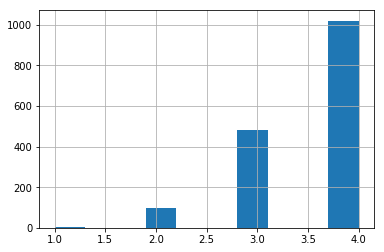

In [22]:
training_data_df[BEST_EPOCH].hist()

In [23]:
training_data_df[TOTAL_DURATION].describe()

count    1600.000000
mean      299.743750
std        17.579996
min       257.000000
25%       289.000000
50%       294.000000
75%       315.000000
max       457.000000
Name: Total_Duration(s), dtype: float64

In [24]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
5,160.0,0.804402,0.007738,0.779928,0.799171,0.804302,0.810339,0.819863
6,160.0,0.803683,0.009220,0.754138,0.799246,0.806634,0.809524,0.816821
2,160.0,0.802787,0.007398,0.779990,0.800078,0.804232,0.808057,0.813894
1,160.0,0.801901,0.008532,0.778827,0.796391,0.802306,0.808162,0.821631
8,160.0,0.801743,0.009598,0.770750,0.797862,0.804290,0.808104,0.819102
0,160.0,0.800668,0.008669,0.779019,0.795045,0.799596,0.807110,0.823231
4,160.0,0.800608,0.008018,0.780123,0.795337,0.800404,0.806507,0.818577
7,160.0,0.800235,0.006807,0.768128,0.797056,0.802150,0.804971,0.812745
3,160.0,0.798679,0.007572,0.764852,0.794442,0.799663,0.804275,0.813198


In [25]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,1600.0,0.801037,0.008422,0.000211,0.800624,0.80145


In [26]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,200,0.800447,0.007354,0.000520,0.799428,0.801466
fasttext,400,0.796664,0.008533,0.000427,0.795828,0.797500
glove,200,0.803377,0.007074,0.000500,0.802396,0.804357
wang2vec,400,0.803049,0.007814,0.000391,0.802283,0.803815
word2vec,400,0.802524,0.008374,0.000419,0.801703,0.803344


In [27]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [28]:
print_anova(EMBEDDING)

Overall model F( 4, 1595) =  44.193, p =  0.00000000000000000000
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     44.19
Date:                Tue, 18 Jun 2019   Prob (F-statistic):           3.18e-35
Time:                        18:34:47   Log-Likelihood:                 5457.2
No. Observations:                1600   AIC:                        -1.090e+04
Df Residuals:                    1595   BIC:                        -1.088e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [29]:
training_data_df[(training_data_df.Embedding == 'wang2vec') & (training_data_df.Embedding_Type == 'skip') & (training_data_df.Representation == 'ELMo+Embeddings')]

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
623,harem-ft_ELMo+Embeddings_wang2vec_skip_0_1,harem-ft,ELMo+Embeddings,wang2vec,skip,0,1,3,5,00:04:49,289.0,57.8,0.990014,0.990842,0.891958,0.879450,0.885660,21.735507,0.978582,0.980767,0.782609,0.826531,0.803970,52.781643,0.977396,0.979122,0.797544,0.802337,0.799933,55.715600
624,harem-ft_ELMo+Embeddings_wang2vec_skip_0_2,harem-ft,ELMo+Embeddings,wang2vec,skip,0,2,4,5,00:04:54,294.0,58.8,0.990137,0.990943,0.894507,0.882686,0.888557,21.823321,0.976287,0.978144,0.796526,0.818878,0.807547,55.925516,0.977606,0.979332,0.822022,0.792654,0.807071,57.284149
625,harem-ft_ELMo+Embeddings_wang2vec_skip_0_3,harem-ft,ELMo+Embeddings,wang2vec,skip,0,3,4,5,00:04:50,290.0,58.0,0.990003,0.990798,0.889434,0.880798,0.885095,21.545571,0.976177,0.978035,0.789216,0.821429,0.805000,58.763950,0.977396,0.979107,0.817406,0.799666,0.808439,56.905376
626,harem-ft_ELMo+Embeddings_wang2vec_skip_0_4,harem-ft,ELMo+Embeddings,wang2vec,skip,0,4,3,5,00:04:52,292.0,58.4,0.989477,0.990316,0.883519,0.877562,0.880530,22.255353,0.978472,0.980876,0.785888,0.823980,0.804483,52.638710,0.977966,0.979692,0.807783,0.804007,0.805890,56.347250
627,harem-ft_ELMo+Embeddings_wang2vec_skip_1_0,harem-ft,ELMo+Embeddings,wang2vec,skip,1,0,4,5,00:04:25,265.0,53.0,0.989416,0.990286,0.884365,0.876513,0.880422,22.802176,0.986756,0.987851,0.860526,0.853786,0.857143,31.248006,0.978311,0.980083,0.832459,0.794658,0.813119,57.530689
628,harem-ft_ELMo+Embeddings_wang2vec_skip_1_1,harem-ft,ELMo+Embeddings,wang2vec,skip,1,1,4,5,00:04:50,290.0,58.0,0.989438,0.990377,0.885598,0.876782,0.881168,22.635752,0.986756,0.987751,0.861619,0.861619,0.861619,31.301906,0.977471,0.979272,0.818431,0.797663,0.807913,58.465097
629,harem-ft_ELMo+Embeddings_wang2vec_skip_1_2,harem-ft,ELMo+Embeddings,wang2vec,skip,1,2,4,5,00:04:59,299.0,59.8,0.989732,0.990580,0.890038,0.879742,0.884860,22.555989,0.987353,0.988449,0.876963,0.874674,0.875817,31.218131,0.977396,0.979227,0.818780,0.788982,0.803605,58.423296
630,harem-ft_ELMo+Embeddings_wang2vec_skip_1_3,harem-ft,ELMo+Embeddings,wang2vec,skip,1,3,4,5,00:04:50,290.0,58.0,0.989438,0.990298,0.889435,0.876513,0.882927,23.073157,0.986357,0.987453,0.866142,0.861619,0.863874,31.042089,0.977021,0.978882,0.818213,0.785977,0.801771,58.314630
631,harem-ft_ELMo+Embeddings_wang2vec_skip_1_4,harem-ft,ELMo+Embeddings,wang2vec,skip,1,4,3,5,00:04:51,291.0,58.2,0.989891,0.990818,0.890914,0.881087,0.885973,22.392685,0.988349,0.989345,0.863402,0.874674,0.869001,29.819369,0.978371,0.980083,0.818025,0.793990,0.805829,54.303022
632,harem-ft_ELMo+Embeddings_wang2vec_skip_2_0,harem-ft,ELMo+Embeddings,wang2vec,skip,2,0,4,5,00:04:27,267.0,53.4,0.989426,0.990243,0.882255,0.875448,0.878838,21.512400,0.981118,0.982076,0.825651,0.874735,0.849485,42.266657,0.977126,0.978987,0.818651,0.794324,0.806304,57.323438
